# 金剛經注疏斷點比對程式

### 處理的經文包含：
- T0235 金剛般若波羅蜜經
- X0489 金剛經註正訛
- X0504 金剛經彙纂
- X0502 金剛經註講
- X0510 金剛經易解
- X0501 金剛經如是經義
- X0497 金剛經石注
- X0498 金剛經正解
- X0486 金剛經會解了義
- X0503 金剛經注解
- X0494 金剛經註釋
- X0485 金剛經如是解
- T1703 金剛般若波羅蜜經註解
- X0500 金剛經法眼註疏
- X0495 金剛經演古
- X0488 金剛經郢
- X0506 金剛經注
- X0509 金剛經解義
- X0508 金剛經闡說
- X0496 金剛經直說
- X0493 金剛經部旨
- X0487金剛新眼疏經偈合釋

## 主程式開始
1. 必要性的引用

In [3]:
import matplotlib as mpl
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import manifold
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import csv



2. 資料準備   
2.1 準備資料容器 
資料內容請準備為如下格式，為兩層次的dict (字典結構)。
- 第一層字典內的每個元素，代表每一個經典的資料，以經號當作Key。
- 經典資料又成為另一個字典(dict)，內部為兩個屬性，title 表示經名，content 表示內容, stops 用來紀錄斷點位置
- content預設值為空，將在後續迴圈內讀取文字檔內容來填補
- stops 預設值為空陣列，將在讀取文字檔完成後，透或函式來計算填補

相似度計算函式

In [4]:
def similarity(stopsA, stopsB):
    """
      兩經文斷點比較函式
      stopsA必須為斷點清單, ex: stopsA=[4,8,12,16]
      stopsB必須為斷點清單, ex: stopsA=[2,4,6,8,10,12,14,16]
      回傳值為混合相似度, 與 A->B, 與 少->多
    """ 

    setA = set(stopsA)
    setB = set(stopsB)
    numA = len(setA)
    numB = len(setB)

    setAB = setA.intersection(setB)

    simScoreAB = len(setAB)/len(setA)  # 計算A->B
    simScoreBA = len(setAB)/len(setB)  # 計算B->A
    #print("len(setAB)"+str(len(setAB)))
    #計算平均
    if len(setAB)==0:
        simScoreAll=0
    else:
        simScoreAll = (2*simScoreAB*simScoreBA)/(simScoreAB+simScoreBA)

    # 計算 少 -> 多
    simScoreBigSmall = 0
    if numA <= numB:
        simScoreBigSmall = simScoreBA
    else:
        simScoreBigSmall = simScoreAB

    return simScoreAll, simScoreAB, simScoreBigSmall


去共同斷點函式

In [5]:
def delete_common_breakpoints(bps):
  """
    bps = {text1: source[text1]["stops"],text2:source[text2]["stops"]....}
  """
  num_all_text = len(bps) # 文件數目，也就是同一位置的最大可能數
  num_all_p = sum([len(bps[tno]) for tno in bps])

  all_pos_count = {}
  # 合併計算所有pos list 中，出現的位置次數
  for tno in bps: 
    for p in bps[tno]:
      if p in all_pos_count: # 計數字典標準用法
        all_pos_count[p]+=1  #累加
      else:
        all_pos_count[p] = 1 #初始化

  # 此段也可以用於統計各斷點位置文件數

  delete_pos =[]
  print("num_all_text={}".format(num_all_text))
  for p in all_pos_count:
    if all_pos_count[p] == num_all_text:
      # 紀錄全部人都有的斷點位置
      delete_pos.append(p)
    # else:
      # print("{}({})".format(p, all_pos_count[p]))

  # print("[進行全重複斷點刪除作業")
  if (len(delete_pos)>0):
    print("[1]將刪除以下全重複斷點:{}".format(",".join([str(dp) for dp in delete_pos])))

  # 進行斷點刪除
  for dp in delete_pos:
    for tno in bps:
      bps[tno].remove(dp)

  # 計算目前總斷點數
  num_all_p_now = sum([len(bps[tno]) for tno in bps])

  # print("[1]全重複斷點刪除完成，總文件數:{}, 刪除前總斷點數:{}, 刪除後總斷點數:{}".format(
  #     num_all_text, num_all_p, num_all_p_now))

  return


### 函式：plot_heatmap

In [6]:
def plot_heatmap(simMatrix):
  # Distance Matrix : 需以numpy dataframe 方式儲存 
  #df.applymap(lambda n: '{:.2f}%'.format(n * 100))
  plt.rc('xtick', labelsize=64)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=64)    # fontsize of the tick labels
  fig, ax = plt.subplots(figsize=(100, 100))
  ax.xaxis.tick_top()
  sns.heatmap(simMatrix, annot=True, cmap='coolwarm', ax=ax, fmt='.2f', annot_kws={"size":32})
  # g.ax_heatmap.set_xticklabels(
  #     g.ax_heatmap.get_xmajorticklabels(), fontsize=16)
  #輸出PNG圖檔

  plt.rcParams['axes.facecolor'] = 'white'
  plt.rcParams['savefig.facecolor'] = 'white'
  
  plt.savefig('heatmap.png')
  plt.show()


In [7]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 20
    plt.rcParams['font.family'] = 'Heiti TC'
    # plt.rcParams['font.sans-serif'] = ['']
    plt.rcParams['axes.unicode_minus'] = False

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


    plt.figure(figsize=(20, 20))


    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # print("model.children_")
    # print(model.children_)
    # print(linkage_matrix)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    plt.tick_params(axis='x', which='major', labelsize=20)
    plt.xticks(rotation=90)    # fontsize of the tick labels
    # plt.title('Hierarchical Clustering')
    plt.show()


In [8]:
def writeSimCSV(sim_martix, keys, csvfile):
  """ sim_martix: 輸入陣列，預設為兩維度 i, j 
      keys 用來找出經號
      csvfile 為輸出對象
  """
  writer = csv.writer(csvfile)
  writer.writerow(['經典A', '經典B', '相似度'])

  for i in range(len(keys)):
    textno1= keys[i]
    for j in range(len(keys)):
      textno2 = keys[j]
      sim_score= sim_martix[i][j]
      writer.writerow([textno1, textno2, sim_score])


  


In [9]:
source_qing= { # 以下32分
          "32-Pure32":{"title":"金剛般若波羅蜜經","dy":"","aType":"","aName":"","content":"", "stops":[]},     
          "32-X0459": {"title": "金剛經解義","dy": "唐", "aType": "僧", "aName": "", "content": "", "stops": []},
          "32-X0461": {"title": "金剛經註", "dy": "南宋", "aType": "僧", "aName": "", "content": "", "stops": []},
          "32-X0489": {"title": "金剛經註正訛", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0503": {"title": "金剛經注解", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0494": {"title": "金剛經註釋", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0498": {"title": "金剛經正解", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0485": {"title": "金剛經如是解", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0501": {"title": "金剛經如是經義", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []},
          "32-X0497": {"title": "金剛經石注", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0469": {"title": "金剛經補註", "dy": "明", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0468": {"title": "金剛經註解", "dy": "明", "aType": "僧", "aName": "", "content": "", "stops": []},
          "32-D8838": {"title": "金剛般若波羅蜜經", "dy": "元", "aType": "僧", "aName": "", "content": "", "stops": []},
          "32-X0486": {"title": "金剛經會解了義", "dy": "明、清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0502": {"title": "金剛經註講", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []},
          "32-X0504": {"title": "金剛經彙纂", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0510": {"title": "金剛經易解", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "32-X0483": {"title": "金剛經音釋直解", "dy": "明", "aType": "僧", "aName": "", "content": "", "stops": []},
      
          # 以下無科文
          "X0454": {"title": "金剛經註", "dy": "姚秦", "aType": "僧", "aName": "", "content": "", "stops": []},
          "X0506": {"title": "金剛經注", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "X0509": {"title": "金剛經解義", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "X0496": {"title": "金剛經直說", "dy": "明、清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "X0482": {"title": "金剛經略疏", "dy": "明、清", "aType": "僧", "aName": "", "content": "", "stops": []},
          "X0508": {"title": "金剛經闡說", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},

          "X0456": {"title": "金剛經註疏", "dy": "唐", "aType": "僧", "aName": "", "content": "", "stops": []},
          # 以下27斷疑
          "27-Pure27": {"title": "金剛般若波羅蜜經", "dy": "", "aType": "", "aName": "", "content": "", "stops": []},
          "27-T2735": {"title": "金剛般若經旨贊", "dy": "唐", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-T1701": {"title": "金剛般若經疏論纂要", "dy": "唐、北宋", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-T1703": {"title": "金剛般若波羅蜜經註解", "dy": "明", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-X0500": {"title": "金剛經法眼註疏", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-X0495": {"title": "金剛經演古", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-X0488": {"title": "金剛經郢說", "dy": "清", "aType": "俗", "aName": "", "content": "", "stops": []},
          "27-X0471": {"title": "金剛經宗通", "dy": "明", "aType": "俗", "aName": "", "content": "", "stops": []},
          "27-X0462": {"title": "金剛經會解", "dy": "南宋", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-X0474": {"title": "金剛經決疑", "dy": "明", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-X0475": {"title": "金剛經鎞", "dy": "明", "aType": "僧", "aName": "", "content": "", "stops": []},
          "27-X0479": {"title": "金剛經破空論", "dy": "明、清", "aType": "僧", "aName": "", "content": "", "stops": []},      
          
          # 以下3分，依各宗派教義
          "3-T1700": {"title": "金剛般若經贊述", "dy": "唐", "aType": "僧", "aName": "", "content": "", "stops": []},
          
          "3-X0464": {"title": "金剛經采微", "dy": "南宋", "aType": "僧", "aName": "", "content": "", "stops": []},
          "3-X0466": {"title": "金剛疏科釋", "dy": "元", "aType": "俗", "aName": "", "content": "", "stops": []},
          "3-X0478": {"title": "金剛經筆記", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []},
          
          "3-X0487": {"title": "金剛新眼疏經偈合釋", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []},
          "3-X0493": {"title": "金剛經部旨", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []},
          "3-X0505": {"title": "金剛經心印疏", "dy": "清", "aType": "僧", "aName": "", "content": "", "stops": []}
          }

# source = source_all
source = source_qing
SIM_CSV_PATH = "SIM.csv"


2.2 讀取文字檔填補內容  
+ 逐一讀取source 內的key, 指派到 textno 變數。
+ 利用textno 的值，組合出應該讀取的文字檔位置(filepath)
+ 讀取文字檔內容，放入對應的content

In [10]:
# Step1. 讀取內容到 source List, 放入 source[textno]["content"]
for textno in source:
    filepath = os.path.join("txt",textno+".txt")
    print("開始讀取:"+filepath+",放到:"+textno+"的content屬性。")
    with open(filepath, "r", encoding="utf-8") as f:
        source[textno]["content"]=f.read()
    print("讀取完成...")

開始讀取:txt/32-Pure32.txt,放到:32-Pure32的content屬性。
讀取完成...
開始讀取:txt/32-X0459.txt,放到:32-X0459的content屬性。
讀取完成...
開始讀取:txt/32-X0461.txt,放到:32-X0461的content屬性。
讀取完成...
開始讀取:txt/32-X0489.txt,放到:32-X0489的content屬性。
讀取完成...
開始讀取:txt/32-X0503.txt,放到:32-X0503的content屬性。
讀取完成...
開始讀取:txt/32-X0494.txt,放到:32-X0494的content屬性。
讀取完成...
開始讀取:txt/32-X0498.txt,放到:32-X0498的content屬性。
讀取完成...
開始讀取:txt/32-X0485.txt,放到:32-X0485的content屬性。
讀取完成...
開始讀取:txt/32-X0501.txt,放到:32-X0501的content屬性。
讀取完成...
開始讀取:txt/32-X0497.txt,放到:32-X0497的content屬性。
讀取完成...
開始讀取:txt/32-X0469.txt,放到:32-X0469的content屬性。
讀取完成...
開始讀取:txt/32-X0468.txt,放到:32-X0468的content屬性。
讀取完成...
開始讀取:txt/32-D8838.txt,放到:32-D8838的content屬性。
讀取完成...
開始讀取:txt/32-X0486.txt,放到:32-X0486的content屬性。
讀取完成...
開始讀取:txt/32-X0502.txt,放到:32-X0502的content屬性。
讀取完成...
開始讀取:txt/32-X0504.txt,放到:32-X0504的content屬性。
讀取完成...
開始讀取:txt/32-X0510.txt,放到:32-X0510的content屬性。
讀取完成...
開始讀取:txt/32-X0483.txt,放到:32-X0483的content屬性。
讀取完成...
開始讀取:txt/X0454.txt,放到:X0454的content屬性。
讀取完成.

In [11]:
# 測試source 內容
# print(source)

3. 計算各經文斷點位置

In [12]:
# Step 2. 由文字檔內容之斷點符號，轉換為vector表達
# 放入 source[textno]["stops"]
for textno in source:
    text = source[textno]["content"]
    source[textno]["stops"]=[] # 確保初始化
    position = 0 # 用來記住現在走到原文的第幾個字
    for char in text: # 一個字一個字走
        if char !="/": # 如果不是 "/"，那就會是原文的字
            position+=1 # 目前位置+1
        else: # 是 "/"，也就是中斷點
            source[textno]["stops"].append(position) # 把中斷點，放入["stops"]裡面
    # 可以打開下一行的comment, 看看stops 到底產生了什麼
    # print(source[textno]["stops"])


3b. 除去共同斷點 -- 所有人都在同一個點中斷，代表該點沒有需要被用來衡量差異性

In [13]:
all_bps = {}
all_bps = dict([(tno, source[tno]["stops"]) for tno in source])
  
num_all_p = sum([len(all_bps[tno]) for tno in all_bps])

print("[0]全重複斷點刪除開始，總文件數:{}, 刪除前總斷點數:{}".format(
    len(source), num_all_p))

delete_common_breakpoints(all_bps)

num_all_p = sum([len(all_bps[tno]) for tno in all_bps])
print("[2]全重複斷點刪除結束，總文件數:{}, 刪除前總斷點數:{}".format(
    len(source), num_all_p))



[0]全重複斷點刪除開始，總文件數:44, 刪除前總斷點數:5489
num_all_text=44
[1]將刪除以下全重複斷點:592,676,1240,3738,4409,4830,5866,6278,6455
[2]全重複斷點刪除結束，總文件數:44, 刪除前總斷點數:5093


4. 比對斷點差異性  
想法如下：
- 若A的斷點為  ---4---8- --12-- -16
- 若B的斷點為  -2-4-6-8-10-12-14-16
- A,B 共同斷點為：4,8,12,16
則A與B有點像又不太像，因為 B 可以說是A的細分
- 所以A為基準，B有所有A的斷點
- 而以B為基準，A又太粗糙
因此在差異比較上，我們應該視A->B 與 B-> A 是不相同的兩件事。
- A->B 的相似度 S(AB)= (A,B 共同斷點數)/A的斷點數, 以上例來說：4/4 = 100%
- B->A 的相似度 S(BA)= (A,B 共同斷點數)/B的斷點數, 以上例來說：4/8 = 50%

混何計算時，參考由presion, recall 算出F1的計算方式，而定義為：
- A,B 斷點相似度為：S(A,B) = 2xS(AB)xS(BA)/(S(AB)+S(BA))
- 以上例來說，S(A,B)= 2x1x0.5 / (1+0.5) = 1/1.5 = 0.66667

範例2:
- 若A的斷點為  ---4---8---- 12-- -16
- 若B的斷點為  -2---6-8---11- -14-16
- A,B 共同斷點為：8,16
則：
- A->B 的相似度 S(AB)= (A,B 共同斷點數)/A的斷點數, 以上例來說：2/4 = 50%
- B->A 的相似度 S(BA)= (A,B 共同斷點數)/B的斷點數, 以上例來說：2/6 = 33.3%
- A,B 斷點相似度為：S(A,B) = 2x0.5x0.33 /(0.5+0.33) = 0.75/1.25 = 0.4

依此概念，完成 similarity 函式



測試 similarity 函式

In [14]:
#  average 與 A->B
# similarity([4,8,12,16],[2,6,8,11,14,16])

實際使用 similarity 函式 

In [15]:
# Step 3.由斷點vector 計算經文科判距離(雙向)

# 建立 keys 清單
keys = list(source.keys())  # 取得souce的所有key, 並轉為list

# 初始化相似度矩陣
sim_matrix = np.zeros(len(keys) ** 2)
sim_matrix = sim_matrix.reshape((len(keys), len(keys)))

sim_matrix_dir = np.zeros(len(keys) ** 2)
sim_matrix_dir = sim_matrix_dir.reshape((len(keys), len(keys)))

# 建立相似度矩陣
for i in range(len(keys)):
    textno1= keys[i]
    title1 = source[textno1]["title"]
    #for j in range(i+1, len(keys)):
    for j in range(len(keys)):
        textno2= keys[j]
        title2 = source[textno2]["title"]
        # 同時傳回 A,B 平均 與 A->B 分數, 與 big->small 分數
        score_avg, score_dir,score_bs = similarity(
            source[textno1]["stops"], source[textno2]["stops"])

        # 雙向平均分
        # sim_matrix[i][j] = score_avg
        sim_matrix[i][j] = score_bs
        sim_matrix_dir[i][j] = score_dir
        
        print("{}({}) 與 {}({}) 之混合相似度為：{:.2f}%".format(
            textno1, title1, textno2, title2, score_avg*100))


with open(SIM_CSV_PATH, 'w', newline='') as csvfile:
    print("輸出相似度矩陣到:{}".format(SIM_CSV_PATH))
    writeSimCSV(sim_matrix, keys, csvfile)



32-Pure32(金剛般若波羅蜜經) 與 32-Pure32(金剛般若波羅蜜經) 之混合相似度為：100.00%
32-Pure32(金剛般若波羅蜜經) 與 32-X0459(金剛經解義) 之混合相似度為：32.39%
32-Pure32(金剛般若波羅蜜經) 與 32-X0461(金剛經註) 之混合相似度為：26.59%
32-Pure32(金剛般若波羅蜜經) 與 32-X0489(金剛經註正訛) 之混合相似度為：32.17%
32-Pure32(金剛般若波羅蜜經) 與 32-X0503(金剛經注解) 之混合相似度為：100.00%
32-Pure32(金剛般若波羅蜜經) 與 32-X0494(金剛經註釋) 之混合相似度為：85.19%
32-Pure32(金剛般若波羅蜜經) 與 32-X0498(金剛經正解) 之混合相似度為：71.88%
32-Pure32(金剛般若波羅蜜經) 與 32-X0485(金剛經如是解) 之混合相似度為：56.79%
32-Pure32(金剛般若波羅蜜經) 與 32-X0501(金剛經如是經義) 之混合相似度為：36.22%
32-Pure32(金剛般若波羅蜜經) 與 32-X0497(金剛經石注) 之混合相似度為：36.80%
32-Pure32(金剛般若波羅蜜經) 與 32-X0469(金剛經補註) 之混合相似度為：40.00%
32-Pure32(金剛般若波羅蜜經) 與 32-X0468(金剛經註解) 之混合相似度為：26.14%
32-Pure32(金剛般若波羅蜜經) 與 32-D8838(金剛般若波羅蜜經) 之混合相似度為：26.29%
32-Pure32(金剛般若波羅蜜經) 與 32-X0486(金剛經會解了義) 之混合相似度為：49.46%
32-Pure32(金剛般若波羅蜜經) 與 32-X0502(金剛經註講) 之混合相似度為：4.97%
32-Pure32(金剛般若波羅蜜經) 與 32-X0504(金剛經彙纂) 之混合相似度為：20.91%
32-Pure32(金剛般若波羅蜜經) 與 32-X0510(金剛經易解) 之混合相似度為：15.38%
32-Pure32(金剛般若波羅蜜經) 與 32-X0483(金剛經音釋直解) 之混合相似度為：35.66%
32-Pure32(金剛般若波羅蜜經) 與 X0454(金剛經

### Run Heatmap

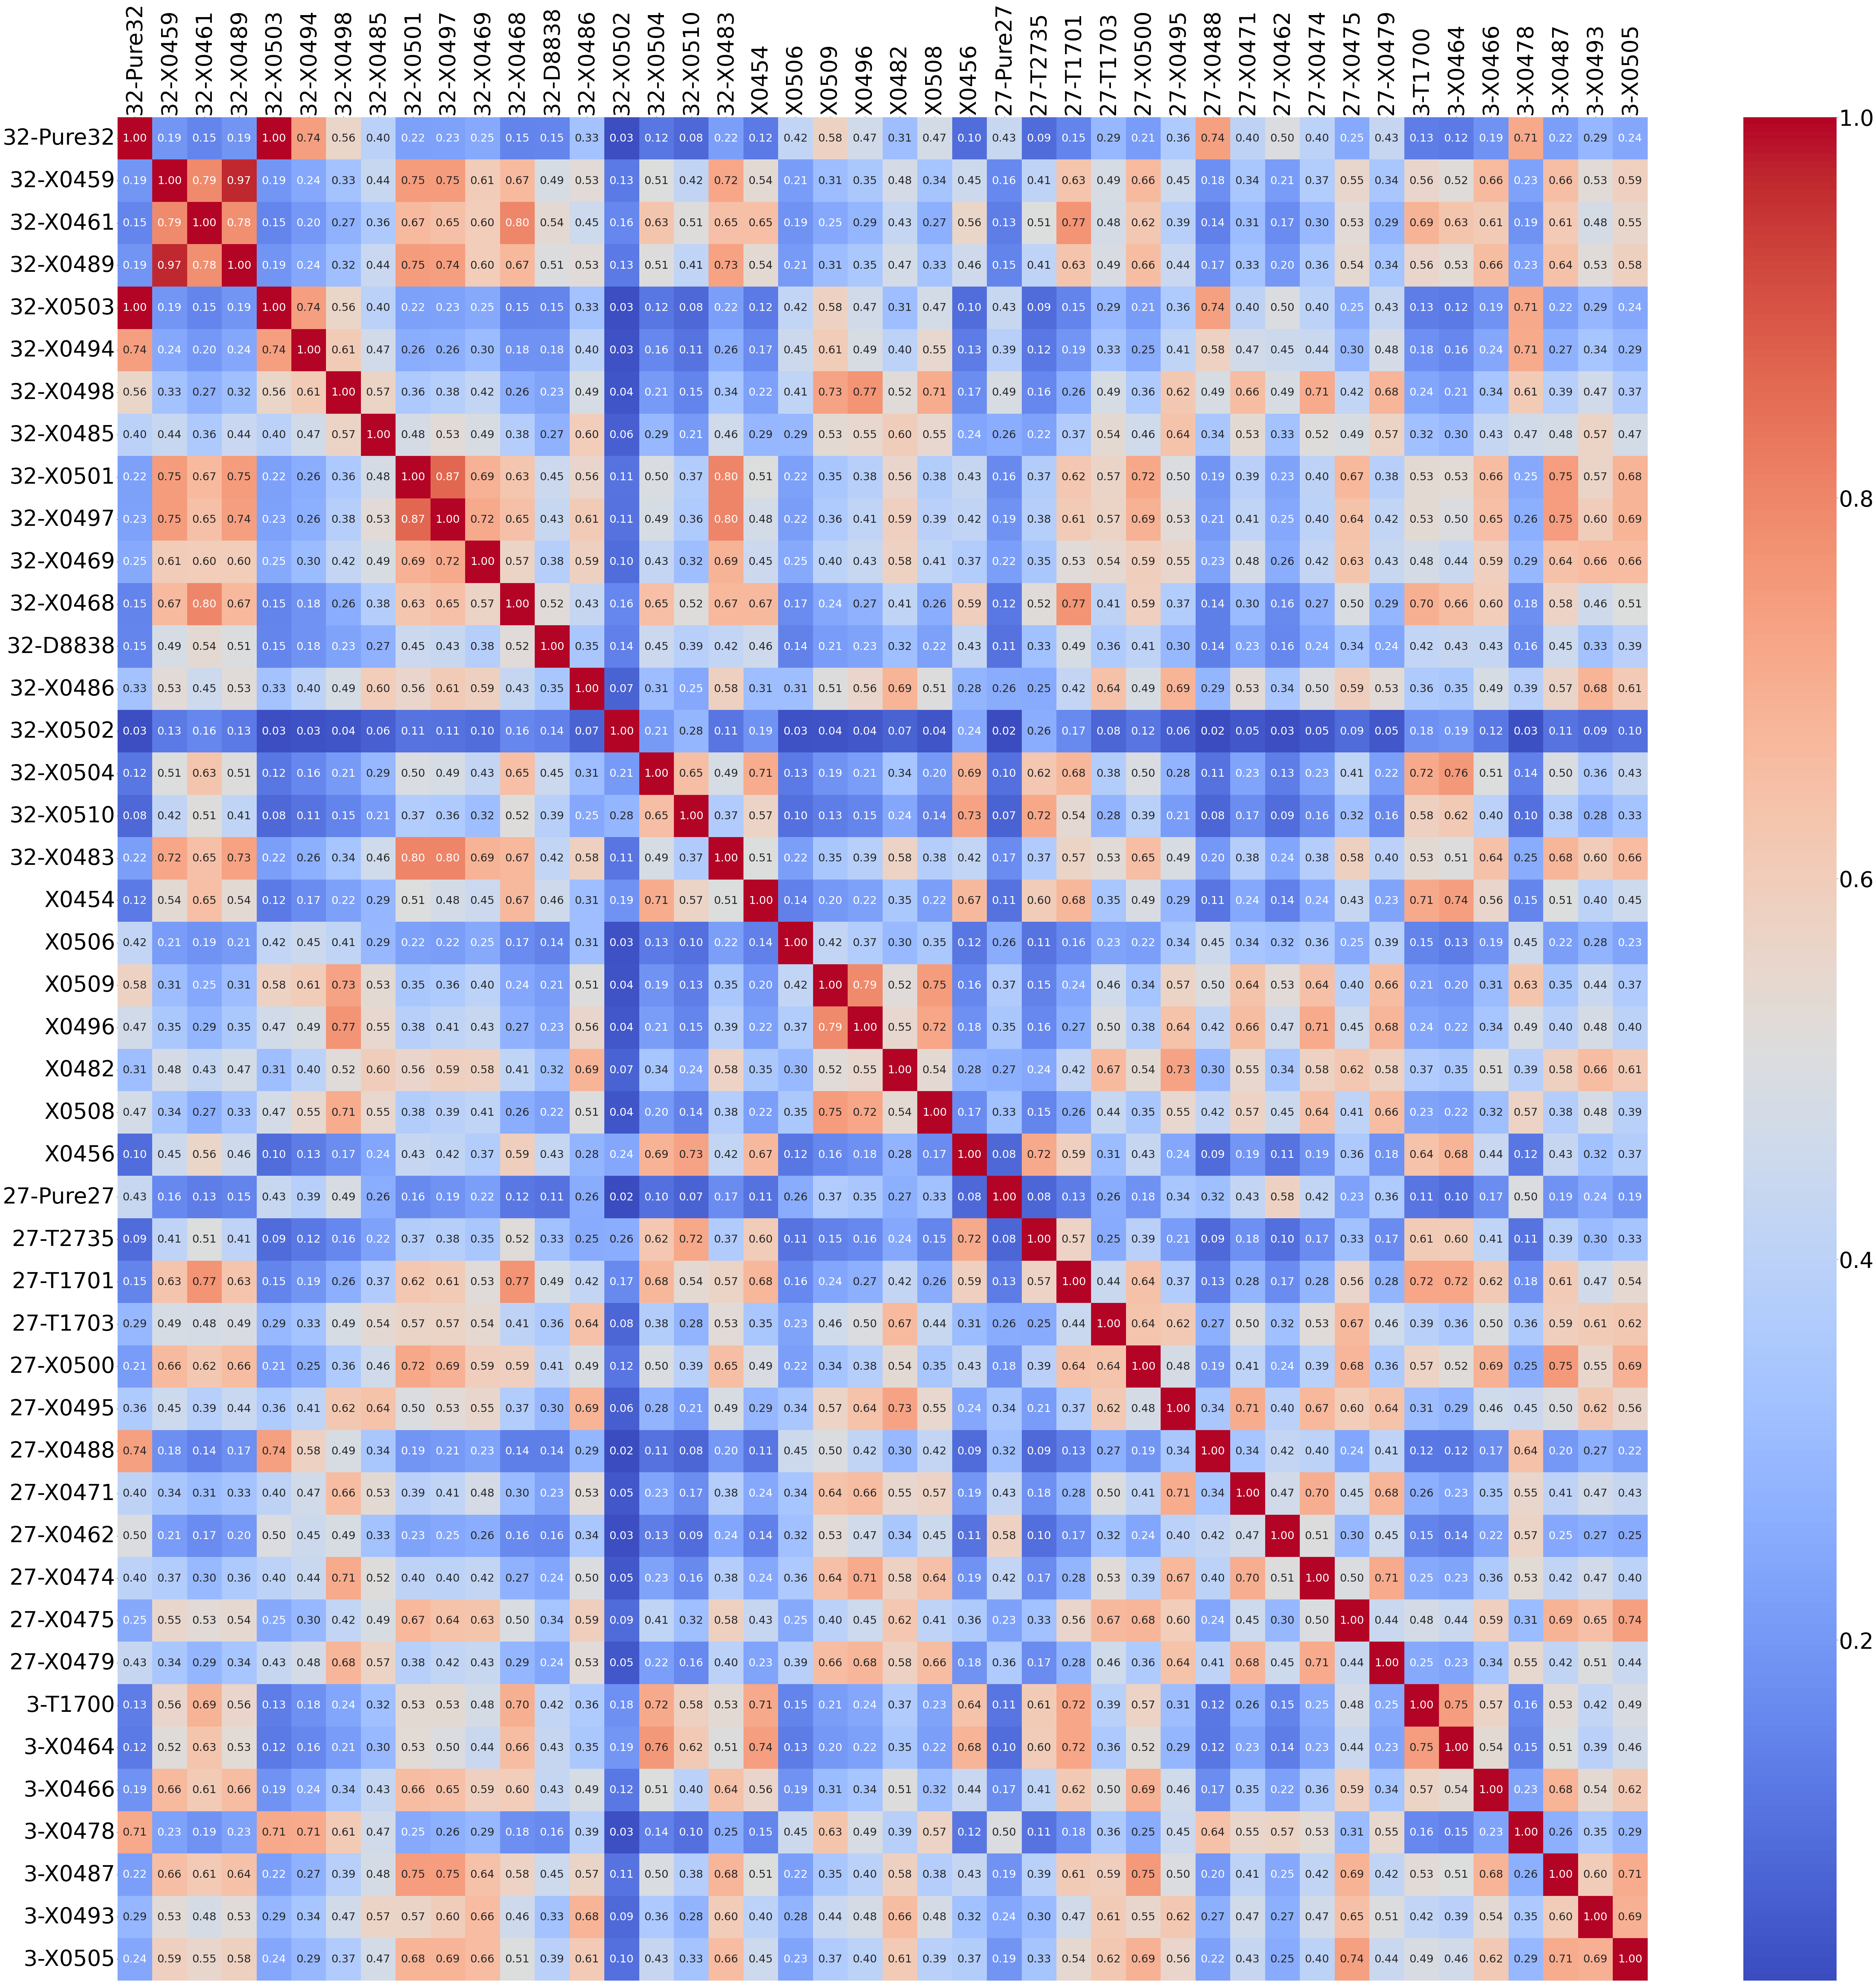

In [16]:
# Step 4.以相似度矩陣繪製HeatMap
df = pd.DataFrame(sim_matrix, columns=keys, index=keys)
plot_heatmap(df)

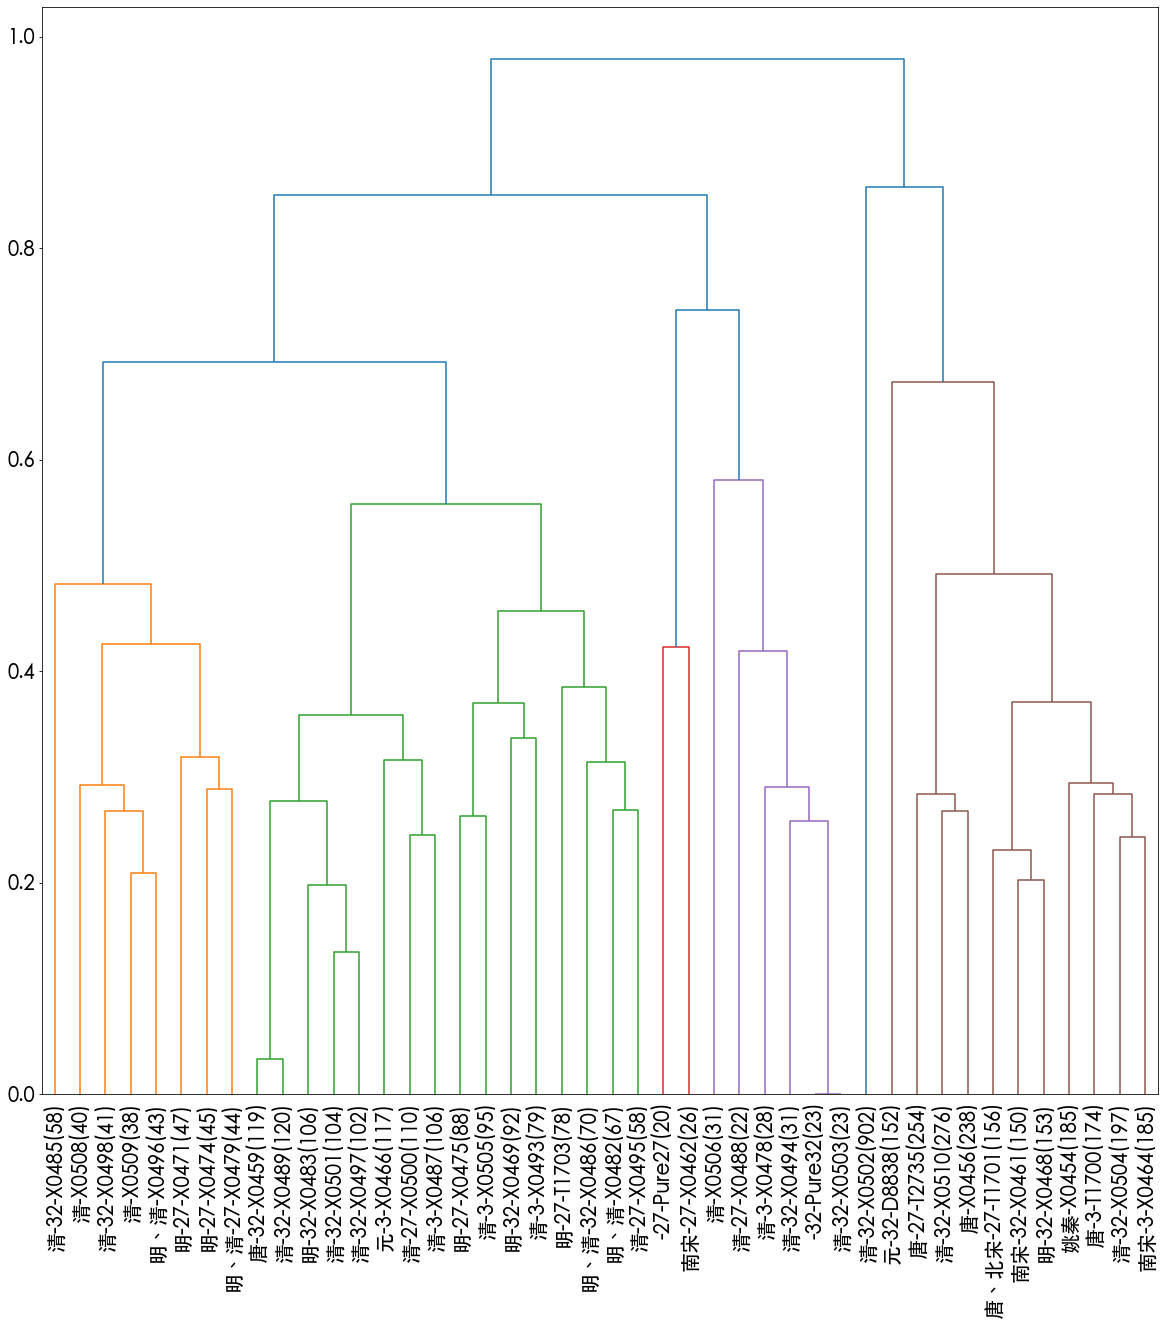

In [17]:
# Step 5.以距離矩陣群聚與進行繪製dendrogram

# 製作距離矩陣 (等於1-similarity 的值 )
dis_matrix = 1-sim_matrix

# masked dis_matrix (大於 TH 的dis, 直接距離設為1)
TH = 1
masked_dis_matrix = np.zeros(len(keys) ** 2)
masked_dis_matrix = masked_dis_matrix.reshape((len(keys), len(keys)))
for i in range(len(keys)):
    for j in range(len(keys)):
        if dis_matrix[i][j] > TH:
            masked_dis_matrix[i][j] = 1
        else:
            masked_dis_matrix[i][j] = dis_matrix[i][j]
        # print("({},{}):{}".format(i, j, masked_dis_matrix[i][j]))



# 進行cluster
ml=AgglomerativeClustering(distance_threshold=0.7, n_clusters=None, affinity='precomputed',linkage='complete')

# 原dis_matrix
# model=ml.fit(dis_matrix)

# 原dis_matrix
model = ml.fit(masked_dis_matrix)

# 設計不同 Label
label_list_all = [
    "{}-{}-{}({})".format(source[k]["dy"], source[k]["aType"], k, len(source[k]["stops"])) for k in source]

label_list_dy = [
    "{}-{}({})".format(source[k]["dy"], k, len(source[k]["stops"])) for k in source]

label_list_atype = [
    "{}-{}({})".format(source[k]["aType"], k, len(source[k]["stops"])) for k in source]

label_list_id = [k for k in source]

# 繪製 dendrogram
plot_dendrogram(model, labels=label_list_dy)


In [29]:
""" 比較 Target 的每個斷點出現在各出現在幾部經典之中 """
target = "X0506"
for pos in all_bps[target]:
  textno_haspos = [tno for tno in all_bps if pos in all_bps[tno]
                   and tno not in ["32-Pure32", "27-Pure27"]]
  print(f"pos={pos}, counts:({len(textno_haspos)-1}), details:")
  print("---")
  print(f"{','.join(textno_haspos)}")
  print("---")


pos=272, counts:(41), details:
---
32-X0459,32-X0461,32-X0489,32-X0503,32-X0494,32-X0498,32-X0485,32-X0501,32-X0497,32-X0469,32-X0468,32-D8838,32-X0486,32-X0502,32-X0504,32-X0510,32-X0483,X0454,X0506,X0509,X0496,X0482,X0508,X0456,27-T2735,27-T1701,27-T1703,27-X0500,27-X0495,27-X0488,27-X0471,27-X0462,27-X0474,27-X0475,27-X0479,3-T1700,3-X0464,3-X0466,3-X0478,3-X0487,3-X0493,3-X0505
---
pos=412, counts:(41), details:
---
32-X0459,32-X0461,32-X0489,32-X0503,32-X0494,32-X0498,32-X0485,32-X0501,32-X0497,32-X0469,32-X0468,32-D8838,32-X0486,32-X0502,32-X0504,32-X0510,32-X0483,X0454,X0506,X0509,X0496,X0482,X0508,X0456,27-T2735,27-T1701,27-T1703,27-X0500,27-X0495,27-X0488,27-X0471,27-X0462,27-X0474,27-X0475,27-X0479,3-T1700,3-X0464,3-X0466,3-X0478,3-X0487,3-X0493,3-X0505
---
pos=472, counts:(22), details:
---
32-X0459,32-X0461,32-X0489,32-X0501,32-X0497,32-X0468,32-X0502,32-X0504,32-X0510,32-X0483,X0454,X0506,X0482,X0456,27-T2735,27-T1701,27-T1703,27-X0500,27-X0474,27-X0475,3-T1700,3-X0464,3-X